In [0]:
!pip install --upgrade -q gspread
!pip install --upgrade -q plotly
!pip install --upgrade -q sklearn


In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials


gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
import pandas as pd
# Open our new sheet and read some data.
worksheet = gc.open('Fire V2').sheet1

# get_all_values gives a list of rows.
#rows = worksheet.get_all_values()
rows = worksheet.get_all_records()
#print(rows)

# Convert to a DataFrame and render.
#pd.DataFrame.from_records(rows)
#investment_df = pd.DataFrame.from_records(rows)
#print(investment_df.head(5))

***Setting up Dataframe***

In [239]:
import calendar
import plotly
import skimage
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import timedelta

now = datetime.datetime.now()
year0 = now.year
month0 = now.month

year1 = now.year - 1
year2 = now.year - 2


print(year0, month0)


#plotly.__version_

2018 10


# ***All Functions***

In [0]:
#Create function to create dummy data for past or future missing investment dates
#this will help heatmap and graphs look better.
def CreateMissingInvestmentDates(missing_investment_df, missing_type='past'):
  #Creating blank dataframe for missing investments dates
  invesments_df =  pd.DataFrame([['place holder', 'place holder', '1985-01-01',0.00,0.00,0.00]],
                            columns=['company','type','first_of_month','begin_balance','end_balance','contributions'])

  
  #creating first of year per past missing investment dates
  missing = int(len(missing_investment_df))
  for x in range(0, missing):
    missing_investment_df['begin_year'] = missing_investment_df['first_of_month'].astype(str).str[:4] + '-01-01'
    missing_investment_df['begin_year'] = pd.to_datetime(missing_investment_df['begin_year'], format='%Y-%m-%d')  
    missing_investment_df['end_year']   = missing_investment_df['first_of_month'].astype(str).str[:4] + '-12-31'
    missing_investment_df['end_year']   = pd.to_datetime(missing_investment_df['end_year'], format='%Y-%m-%d')  
  
  for x in range(0,missing):
      company       = missing_investment_df['company'][x]
      company_type  = missing_investment_df['type'][x]
      #differnt date range if its in the past or future.
      if missing_type == 'past':
        start         = missing_investment_df['begin_year'][x]
        end           = missing_investment_df['first_of_month'][x]
        date_range    = pd.date_range(start=start, end=end, freq='MS', closed='left')
      else:
        start         = missing_investment_df['first_of_month'][x]
        end           = missing_investment_df['end_year'][x]
        date_range    = pd.date_range(start=start, end=end, freq='MS', closed='right')        
      df            = pd.DataFrame(date_range, columns=['first_of_month'])
      df['company'] = company
      df['type']    = company_type
      df['first_of_month']   = pd.to_datetime(df['first_of_month'], format='%Y-%m-%d')
      invesments_df = invesments_df.append(df)
 
  #converting NA to 0 for balances
  invesments_df['begin_balance'] = invesments_df.begin_balance.fillna(0)
  invesments_df['end_balance']   = invesments_df.end_balance.fillna(0)
  invesments_df['contributions'] = invesments_df.contributions.fillna(0)
  #returning df in the function
  return invesments_df

def CreateMonthlyHeatMap(investment_df, title = "Monthly ROR Title 1"):
  #distinct list of values for map
  years         = investment_df.tran_year.unique()
  month_num     = investment_df.tran_month.unique()
  month_name    = investment_df.tran_month_name.unique()
  #was looking at now.year and now.month, but issue ran when those values where not populated yet.
  #current_df_values = investment_df[investment_df.end_balance != 0.0].sort_values('first_of_month', ascending=False).head(1)
  #current_year = current_df_values.tran_year
  #current_month = current_df_values.tran_month
  current_year = now.year
  current_month = now.month
  

  #Creating the empty grid
  row = int(len(years))
  column = int(len(month_num))
  A = np.zeros([row,column], dtype="float64")

  #filling in the grid
  for x in range(0, row):
    c_year = years[x]
    for y in range(0,column):
      c_month = month_num[y]
      a = investment_df[(investment_df.tran_year == c_year) & (investment_df.tran_month == c_month)].mror
      #print(c_month, c_year,a)
      A[x,y] = a #updating grid with current ROR 
  
  #grid settings
  #df = pd.DataFrame(A, columns=current_month)

  #showing the grid    
  ax = sns.heatmap(A, linewidth=0.5, annot=True, robust=True, square=False, xticklabels=month_name, yticklabels=years, cmap="PiYG")
  ax.set_title(title)

  plt.show()
  #return plt

def CreateYTDReturnHeatMap(investment_df, title = 'YTD ROR Title 1'):
  print("test 1")

# ***Transform The Data***

In [0]:

#droping the dataframe
#investment_df.drop

#Initliazting the dataframe
investment_df = pd.DataFrame.from_records(rows)


################################################################################
'''
        Logic for misssing dates either past or future
        helps with graphs look pretty as well as heatmap
'''
  #grabbing min and max dates per investment
min_investment_dates = investment_df.groupby(['company','type'],as_index=False)['first_of_month'].min()
max_investment_dates = investment_df.groupby(['company','type'],as_index=False)['first_of_month'].max()
  #converting first_of_month to datetime format 
min_investment_dates['first_of_month'] = pd.to_datetime(min_investment_dates['first_of_month'], format='%Y-%m-%d')
max_investment_dates['first_of_month'] = pd.to_datetime(max_investment_dates['first_of_month'], format='%Y-%m-%d')

  #Creating blank dataframe for missing investments dates
missing_invesments_df =  pd.DataFrame([['place holder', 'place holder', '1985-01-01',0.00,0.00,0.00]],
                                columns=['company','type','first_of_month','begin_balance','end_balance','contributions'])

past_missing_df   = CreateMissingInvestmentDates(min_investment_dates, missing_type='past')
future_missing_df = CreateMissingInvestmentDates(max_investment_dates, missing_type='future')
investment_df = investment_df.append(past_missing_df)
investment_df = investment_df.append(future_missing_df)
################################################################################




################################################################################
'''
        Random Variables
'''
#convert date column to a datetime format
investment_df['first_of_month'] =  pd.to_datetime(investment_df['first_of_month'], format='%Y-%m-%d')

#setting up helper columns
investment_df['tran_year']       = pd.DatetimeIndex(investment_df.first_of_month).year
investment_df['tran_month']      = pd.DatetimeIndex(investment_df.first_of_month).month
investment_df['tran_month_name'] = investment_df['tran_month'].apply(lambda x: calendar.month_abbr[x])
investment_df['mror']            = np.round((((investment_df.end_balance - investment_df.begin_balance - investment_df.contributions)/(investment_df.end_balance - investment_df.contributions))*100),decimals=2)

#Update NaN values
investment_df['mror'] = investment_df.mror.fillna(0)

#Remove place holder rows
investment_df = investment_df[investment_df.tran_year != 1985]
################################################################################


################################################################################
'''
          Remove outliers
'''
    #would like to do this in a loop for each investment type rather than the entire portfolio
    #also would like to look at STD
postive_median        = investment_df.loc[(investment_df['mror']>=0) &(investment_df['mror']<=30), 'mror'].median()
investment_df["mror"] = np.where(investment_df["mror"] >30, postive_median,investment_df['mror'])
negative_median       = investment_df.loc[(investment_df['mror']>-30.0)&(investment_df['mror']<=0.0), 'mror'].median()
investment_df["mror"] = np.where(investment_df["mror"] <=-30.0, negative_median,investment_df['mror'])
################################################################################

#final re-ordering
investment_df = investment_df.sort_values(['company','type','tran_year','tran_month'], ascending=True)

#print(investment_df[(investment_df.company == 'Farm Credit') &(investment_df.type == 'HSA')].sort_values('mror'))


# ***Monthly ROR Heat Maps***

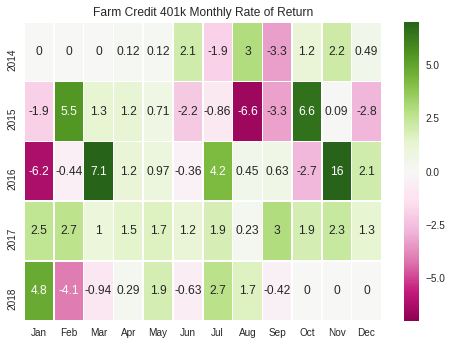

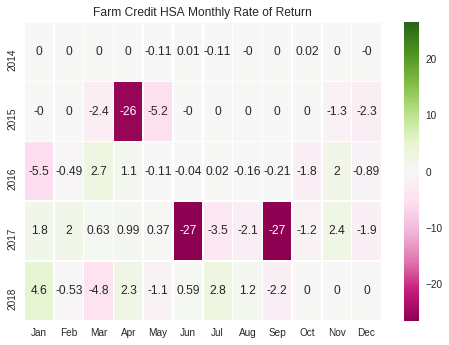

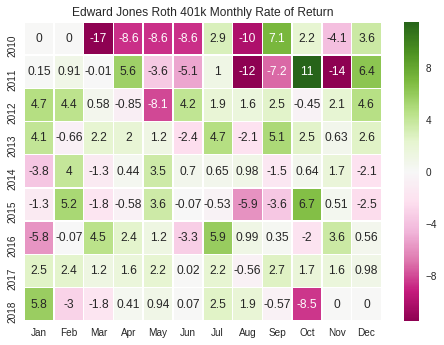

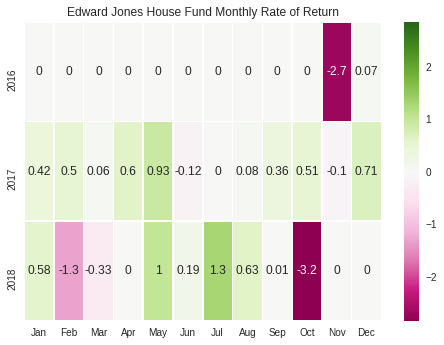

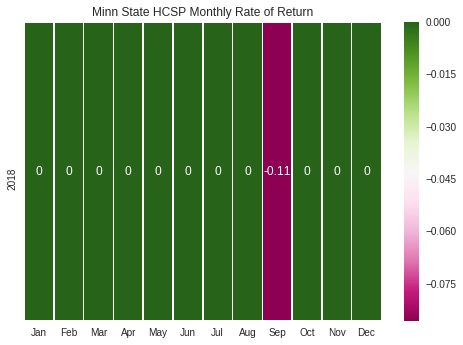

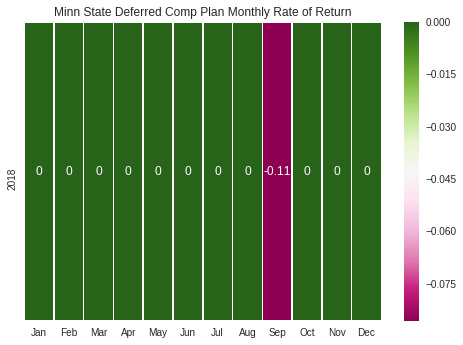

In [242]:
#########################################
##########Farm Credit####################
#########################################
fc_401k_df = investment_df[(investment_df.company == 'Farm Credit') & (investment_df.type == '401k')]
CreateMonthlyHeatMap(fc_401k_df, 'Farm Credit 401k Monthly Rate of Return')

fc_hsa_df = investment_df[(investment_df.company == 'Farm Credit') & (investment_df.type == 'HSA')]
CreateMonthlyHeatMap(fc_hsa_df, 'Farm Credit HSA Monthly Rate of Return') 
#########################################


#########################################
##########Edward Jones###################
ej_roth_df = investment_df[(investment_df.company == 'Edward Jones') & (investment_df.type == 'Roth 401k')]
CreateMonthlyHeatMap(ej_roth_df, 'Edward Jones Roth 401k Monthly Rate of Return') 

ej_house_df = investment_df[(investment_df.company == 'Edward Jones') & (investment_df.type == 'House Fund')]
CreateMonthlyHeatMap(ej_house_df, 'Edward Jones House Fund Monthly Rate of Return') 
#########################################

#########################################
##########Minn State#####################
minnstate_hcsp_df = investment_df[(investment_df.company == 'Minn State') & (investment_df.type == 'HCSP')]
CreateMonthlyHeatMap(minnstate_hcsp_df, 'Minn State HCSP Monthly Rate of Return') 

minnstate_deferredcomp_df = investment_df[(investment_df.company == 'Minn State') & (investment_df.type == 'Deferred Comp Plan')]
CreateMonthlyHeatMap(minnstate_deferredcomp_df, 'Minn State Deferred Comp Plan Monthly Rate of Return') 

#need to add pension plan

#########################################

# ***Investment Balances Over Time By Investment***

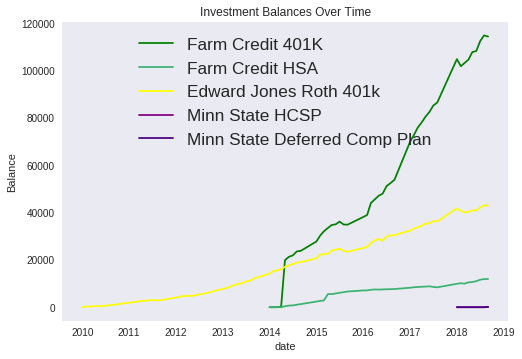

In [250]:
#balances over time
current_year  = now.year
current_month = now.month
balances_df = investment_df[(investment_df.tran_year <= current_year) & (investment_df.tran_month < current_month)][['company', 'type', 'first_of_month','end_balance']]
#balances_df = balances_df.assign(investment_name = balances_df.company.astype(str) + ' - ' + balances_df.type.astype(str))

################################################################################
###################Grabbing data points for lines###############################
#########################Farm Credit############################################
#maybe put logic in function
fc_401k_df = balances_df[(balances_df.company == 'Farm Credit') & (balances_df.type == '401k')][['first_of_month','end_balance']]
x0 = fc_401k_df[['first_of_month']]
y0 = fc_401k_df[['end_balance']]

fc_HSA_df = balances_df[(balances_df.company == 'Farm Credit') & (balances_df.type == 'HSA')][['first_of_month','end_balance']]
x1 = fc_HSA_df[['first_of_month']]
y1 = fc_HSA_df[['end_balance']]
#########################Edwards Jones##########################################
#maybe put logic in function
ej_401k_df = balances_df[(balances_df.company == 'Edward Jones') & (balances_df.type == 'Roth 401k')][[ 'first_of_month','end_balance']]
x2 = ej_401k_df[['first_of_month']]
y2 = ej_401k_df[['end_balance']]

#ej_housefund_df = balances_df[(balances_df.company == 'Edward Jones') & (balances_df.type == 'House Fund')][[ 'first_of_month','end_balance']]
#x3 = ej_housefund_df[['first_of_month']]
#y3 = ej_housefund_df[['end_balance']]
########################Minn State##############################################
minnstate_hcsp_df = balances_df[(balances_df.company == 'Minn State') & (balances_df.type == 'HCSP')][['first_of_month','end_balance']]
x4 = minnstate_hcsp_df[['first_of_month']]
y4 = minnstate_hcsp_df[['end_balance']]

minnstate_deferredcomp_df = balances_df[(balances_df.company == 'Minn State') & (balances_df.type == 'Deferred Comp Plan')][[ 'first_of_month','end_balance']]
x5 = minnstate_deferredcomp_df[['first_of_month']]
y5 = minnstate_deferredcomp_df[['end_balance']]
#need to add pension
################################################################################


################################################################################
##################Graphing out lines############################################
fig, ax = plt.subplots()
ax.plot(x0,y0, 'k', color = 'Green',label = 'Farm Credit 401K')
ax.plot(x1,y1, 'k', color = 'MediumSeaGreen', label = 'Farm Credit HSA')
ax.plot(x2,y2, 'k', color = 'Yellow', label = 'Edward Jones Roth 401k')
#ax.plot(x3,y3, 'k', color = 'Gold', label = 'Edward Jones House Fund')
ax.plot(x4,y4, 'k', color = 'Purple', label = 'Minn State HCSP')
ax.plot(x5,y5, 'k', color = 'Indigo', label = 'Minn State Deferred Comp Plan')


ax.set(xlabel='date', ylabel='Balance',title='Investment Balances Over Time')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.grid()

plt.show()
################################################################################


# ***Investment Balances Over Time By Type***

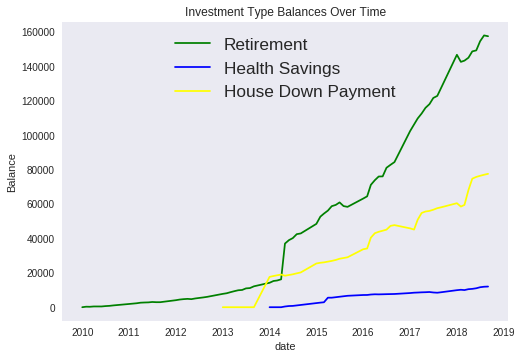

In [247]:
#######################Groupings################################################
#balances_df.loc[ balances_df.type == 'HCSP', 'groupings' ] = 'Health Savings'
balances_df.loc[ balances_df.type.isin(['401k', 'Roth 401k','Deferred Comp Plan']),'groupings'] = 'Retirement'
balances_df.loc[ balances_df.type.isin(['HCSP', 'HSA']),'groupings'] = 'Health Savings'
balances_df.loc[ balances_df.type.isin(['House Fund' ]),'groupings'] = 'House Down Payment'
################################################################################

#######################Summing Groupings########################################
balances_summed_df = balances_df.groupby(['groupings', 'first_of_month'], as_index=False).sum()
################################################################################


###################Grabbing data points for lines###############################
retirement_df = balances_summed_df[(balances_summed_df.groupings == 'Retirement')][['first_of_month','end_balance']]
x0 = retirement_df[['first_of_month']]
y0 = retirement_df[['end_balance']]

health_savings_df = balances_summed_df[(balances_summed_df.groupings == 'Health Savings')][['first_of_month','end_balance']]
x1 = health_savings_df[['first_of_month']]
y1 = health_savings_df[['end_balance']]

house_downpayment_df = balances_summed_df[(balances_summed_df.groupings == 'House Down Payment')][['first_of_month','end_balance']]
x2 = house_downpayment_df[['first_of_month']]
y2 = house_downpayment_df[['end_balance']]

##################Graphing out lines############################################
fig, ax = plt.subplots()
ax.plot(x0,y0, 'k', color = 'Green',label = 'Retirement')
ax.plot(x1,y1, 'k', color = 'Blue', label = 'Health Savings')
ax.plot(x2,y2, 'k', color = 'Yellow', label = 'House Down Payment')

ax.set(xlabel='date', ylabel='Balance',title='Investment Type Balances Over Time')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.grid()

plt.show()

################################################################################

# ***Yearly Rate of Return***

In [21]:
#Getting past three years of data for all investments
past_investment_df = investment_df[(investment_df.tran_year.isin([year0, year1, year2]))]

#Farm Credit 401k Data
all_fc_df = investment_df[(investment_df.company == 'Farm Credit') & (investment_df.type == '401k')]

fc_df = past_investment_df[(past_investment_df.company == 'Farm Credit') & (past_investment_df.type == '401k')]
fc_df_y0 = fc_df[(fc_df.tran_year == year0)][['mror','tran_month','tran_month_name']]
fc_df_y1 = fc_df[(fc_df.tran_year == year1)][['mror','tran_month','tran_month_name']]
fc_df_y2 = fc_df[(fc_df.tran_year == year2)][['mror','tran_month','tran_month_name']]

#Farm Credit HSA Data
hsa_df = past_investment_df[(past_investment_df.company == 'Farm Credit') & (investment_df.type == 'HSA')]
hsa_df_y0 = hsa_df[(hsa_df.tran_year == year0)][['mror','tran_month','tran_month_name']]
hsa_df_y1 = hsa_df[(hsa_df.tran_year == year1)][['mror','tran_month','tran_month_name']]
hsa_df_y2 = hsa_df[(hsa_df.tran_year == year2)][['mror','tran_month','tran_month_name']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



### ***Farm Credit Past Three Years of Monthly Rate of Return***

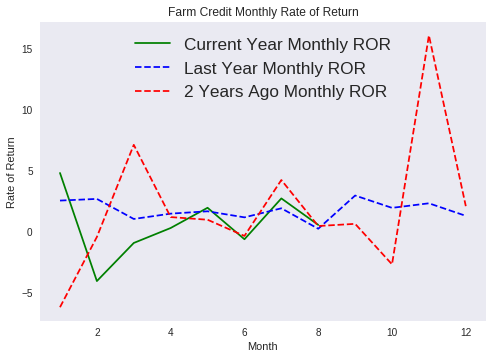

In [284]:
#current year
x0 = fc_df_y0[['tran_month']]
y0 = fc_df_y0[['mror']]
#last year
x1 = fc_df_y1[['tran_month']]
y1 = fc_df_y1[['mror']]
#two years ago
x2 = fc_df_y2[['tran_month']]
y2 = fc_df_y2[['mror']]


#plotting out graph
fig, ax = plt.subplots()
ax.plot(x0, y0, 'k'  , color='green', label = 'Current Year Monthly ROR')
ax.plot(x1, y1, 'k--', color='blue' , label = 'Last Year Monthly ROR')
ax.plot(x2, y2, 'k--', color='red'  , label = '2 Years Ago Monthly ROR')

ax.set(xlabel='Month', ylabel='Rate of Return',title='Farm Credit Monthly Rate of Return')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.grid()

#fig.savefig("FC_ror.png")
plt.show()

# **Heat Map**

     begin_balance      company  contributions  end_balance first_of_month  \
0             1.00  Farm Credit         164.61       164.52     2014-04-01   
1           164.52  Farm Credit       19489.99     19904.11     2014-05-01   
2         19904.11  Farm Credit        1000.00     21322.68     2014-06-01   
3         21322.68  Farm Credit        1000.00     21922.48     2014-07-01   
4         21922.48  Farm Credit        1000.00     23591.30     2014-08-01   
5         23591.30  Farm Credit        1000.00     23835.09     2014-09-01   
6         23835.09  Farm Credit        1000.00     25121.05     2014-10-01   
7         25121.05  Farm Credit        1000.00     26677.28     2014-11-01   
8         26677.28  Farm Credit         500.00     27308.31     2014-12-01   
9         27308.31  Farm Credit        1000.00     27791.49     2015-01-01   
10        27791.49  Farm Credit        1000.00     30397.70     2015-02-01   
11        30397.70  Farm Credit        1300.90     32111.62     

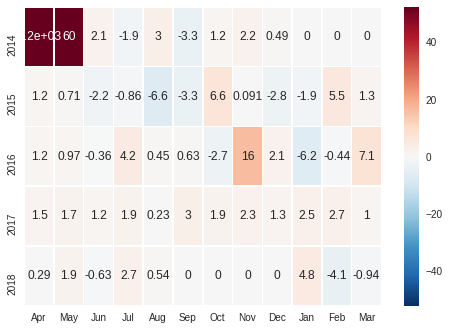

In [22]:
import skimage
import random
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#distinct list of values for map
years      = all_fc_df.tran_year.unique()
month_num  = all_fc_df.tran_month.unique()
month_name = all_fc_df.tran_month_name.unique()
current_year = now.year
current_month = now.month

#Creating the empty grid
row = int(len(years))
column = int(len(month_num))
A = np.zeros([row,column], dtype="float64")


#filling in the grid
for x in range(0, row):
  c_year = years[x]
  for y in range(0,column):
    c_month = month_num[y]
    #future months will always be 0 otherwise grab the ror
    if c_month > current_month and c_year == current_year:
      a = 0
    elif c_month <= 3 and c_year == 2014:
      a = 0
    else:
      a = all_fc_df[(all_fc_df.tran_year == c_year) & (all_fc_df.tran_month == c_month)].mror
  
    A[x,y] = a #updating grid with current ROR 
    

#grid settings
#df = pd.DataFrame(A, columns=current_month)

print(all_fc_df)

#showing the grid    
ax = sns.heatmap(A, linewidth=0.5, annot=True, robust=True, square=False, xticklabels=month_name, yticklabels=years)

#ax.set_xticketlabels(ax.get_xticklabels(), rotation=90)

plt.show()

## ***Farm Credit HSA Monthly Rate of Return***

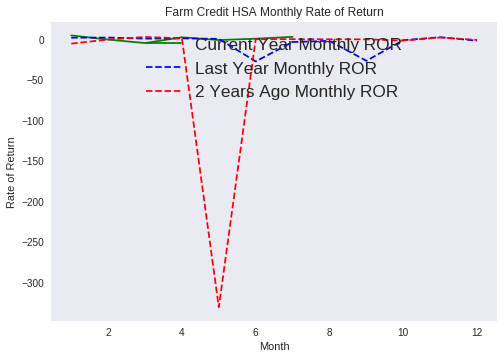

In [271]:
#current year
x0 = hsa_df_y0[['tran_month']]
y0 = hsa_df_y0[['mror']]
#last year
x1 = hsa_df_y1[['tran_month']]
y1 = hsa_df_y1[['mror']]
#two years ago
x2 = hsa_df_y2[['tran_month']]
y2 = hsa_df_y2[['mror']]


#plotting out graph
fig, ax = plt.subplots()
ax.plot(x0, y0, 'k'  , color='green', label = 'Current Year Monthly ROR')
ax.plot(x1, y1, 'k--', color='blue' , label = 'Last Year Monthly ROR')
ax.plot(x2, y2, 'k--', color='red'  , label = '2 Years Ago Monthly ROR')

ax.set(xlabel='Month', ylabel='Rate of Return',title='Farm Credit HSA Monthly Rate of Return')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.grid()

#fig.savefig("FC_ror.png")
plt.show()

In [194]:


investment_df = pd.DataFrame.from_records(rows)
#grabbing min and max dates per investment
min_investment_dates = investment_df.groupby(['company','type'],as_index=False)['first_of_month'].min()
max_investment_dates = investment_df.groupby(['company','type'],as_index=False)['first_of_month'].max()
#converting first_of_month to datetime format 
min_investment_dates['first_of_month'] = pd.to_datetime(min_investment_dates['first_of_month'], format='%Y-%m-%d')
max_investment_dates['first_of_month'] = pd.to_datetime(max_investment_dates['first_of_month'], format='%Y-%m-%d')

#Creating blank dataframe for missing investments dates
missing_invesments_df =  pd.DataFrame([['place holder', 'place holder', '01-01-1985',0.00,0.00,0.00]],
                            columns=['company','type','first_of_month','begin_balance','end_balance','contributions'])



'''
#creating first of year per past missing investment dates
past_missing = int(len(min_investment_dates))
for x in range(0, past_missing):
  min_investment_dates['begin_year'] = min_investment_dates['first_of_month'].astype(str).str[:4] + '-01-01'
  min_investment_dates['begin_year'] = pd.to_datetime(min_investment_dates['begin_year'], format='%Y-%m-%d')  

for x in range(0,past_missing):
  start   = min_investment_dates['begin_year'][x]
  end     = min_investment_dates['first_of_month'][x]
  company = min_investment_dates['company'][x]
  company_type    = min_investment_dates['type'][x]
  past_date_range = pd.date_range(start=start, end=end, freq='MS', closed='left')
  df = pd.DataFrame(past_date_range, columns=['first_of_month'])
  df['company'] = company
  df['type'] = company_type
  df['first_of_month']   = pd.to_datetime(df['first_of_month'], format='%Y-%m-%d')
  missing_invesments_df = missing_invesments_df.append(df)
'''
#creating end of year for future missing investment dates

  
#removing NA to 0  
#missing_invesments_df['begin_balance'] = missing_invesments_df.begin_balance.fillna(0)
#missing_invesments_df['end_balance']   = missing_invesments_df.end_balance.fillna(0)
#missing_invesments_df['contributions'] = missing_invesments_df.contributions.fillna(0)


#past_missing_df = CreateMissingInvestmentDates(min_investment_dates, missing_type='past')


print(max_investment_dates)
print('-'*100)
future_missing_df = CreateMissingInvestmentDates(max_investment_dates, missing_type='future')

print(future_missing_df)



  
  
#print(min_investment_dates.dtypes)  




#creating last of the year per future missing
#future_missing = int(len(max_investment_dates))
#for x in range(0, future_missing):
#  max_investment_dates['end_year'] = max_investment_dates['first_of_month'].astype(str).str[:4] + '-12-31'

#convert new datetime fields to correct format
#min_investment_dates['begin_year'] = pd.to_datetime(min_investment_dates['begin_year'], format='%Y-%m-%d')
#max_investment_dates['end_year']   = pd.to_datetime(max_investment_dates['end_year'], format='%Y-%m-%d')


#min_investment_dates['first_of_month'] = pd.to_datetime(min_investment_dates['first_of_month'])

#print(min_investment_dates.dtypes)
#print(max_investment_dates)

#print(missing_past_invesments_df.dtypes)


'''

missing_fc_401k_df = pd.DataFrame([[0.00, 'Farm Credit',0.00, 0.00,'2014-01-01','401k'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-02-01','401k'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-03-01','401k']], 
                             columns=['begin_balance','company','contributions','end_balance','first_of_month','type'])

missing_fc_hsa_df = pd.DataFrame([[0.00, 'Farm Credit',0.00, 0.00,'2014-01-01','HSA'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-02-01','HSA'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-03-01','HSA'],
                              [0.00, 'Farm Credit',0.00, 0.00,'2014-04-01','HSA']], 
                             columns=['begin_balance','company','contributions','end_balance','first_of_month','type'])

missing_ej_roth_df = pd.DataFrame([[0.00, 'Edward Jones',0.00, 0.00,'2010-01-01','Roth 401k']], 
                             columns=['begin_balance','company','contributions','end_balance','first_of_month','type'])



#appending missing with current df (want to do this dynamtic later)
investment_df = investment_df.append(missing_fc_401k_df)
'''

'''
#creating past missing date records to be 0.
past_rows_missing = int(len(min_investment_dates))
#print(past_rows_missing)
for x in range(0, past_rows_missing):
  print(min_investment_dates['company'][x],min_investment_dates['type'][x])
  for y in range(0, min_investment_dates['tran_month'][x],-1):
    print('test')
'''  
#  print(past_rows_missing['company'])






#print(min_investment_dates)
#print(max_investment_dates)



'''


#convert date column to a datetime format
investment_df['first_of_month'] =  pd.to_datetime(investment_df['first_of_month'], format='%Y-%m-%d')


#adding entries for end of year
missing_month_count = abs( max(investment_df['first_of_month']).month - 12)
missing_date =  max(investment_df['first_of_month']) + pd.DateOffset(months=1)

for m in range(0,missing_month_count):
  print(m)
  missing_date = max(investment_df['first_of_month']) + pd.DateOffset(months=1)
  current_year_missing = pd.DataFrame([[0.00, 'Farm Credit',0.00, 0.00,missing_date,'401k'],
                              [0.00, 'Farm Credit',0.00, 0.00,missing_date,'HSA'],
                              [0.00, 'Edward Jones',0.00, 0.00,missing_date,'Roth 401k']], 
                             columns=['begin_balance','company','contributions','end_balance','first_of_month','type'])
  investment_df = investment_df.append(current_year_missing)
 

'''


        company       type first_of_month
0  Edward Jones  Roth 401k     2018-10-01
1   Farm Credit       401k     2018-08-01
2   Farm Credit        HSA     2018-07-01
----------------------------------------------------------------------------------------------------
hello
DatetimeIndex(['2018-11-01', '2018-12-01'], dtype='datetime64[ns]', freq='MS')
hello
DatetimeIndex(['2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'], dtype='datetime64[ns]', freq='MS')
hello
DatetimeIndex(['2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')
   begin_balance       company  contributions  end_balance  \
0            0.0  place holder            0.0          0.0   
0            0.0  Edward Jones            0.0          0.0   
1            0.0  Edward Jones            0.0          0.0   
0            0.0   Farm Credit            0.0          0.0   
1            0.0   Farm Credit            0.0          0.0   
2    

"\n\n\n#convert date column to a datetime format\ninvestment_df['first_of_month'] =  pd.to_datetime(investment_df['first_of_month'], format='%Y-%m-%d')\n\n\n#adding entries for end of year\nmissing_month_count = abs( max(investment_df['first_of_month']).month - 12)\nmissing_date =  max(investment_df['first_of_month']) + pd.DateOffset(months=1)\n\nfor m in range(0,missing_month_count):\n  print(m)\n  missing_date = max(investment_df['first_of_month']) + pd.DateOffset(months=1)\n  current_year_missing = pd.DataFrame([[0.00, 'Farm Credit',0.00, 0.00,missing_date,'401k'],\n                              [0.00, 'Farm Credit',0.00, 0.00,missing_date,'HSA'],\n                              [0.00, 'Edward Jones',0.00, 0.00,missing_date,'Roth 401k']], \n                             columns=['begin_balance','company','contributions','end_balance','first_of_month','type'])\n  investment_df = investment_df.append(current_year_missing)\n \n\n"